In [49]:
import random

In [50]:
class Transaction:
  def __init__(self,id,sender,cycle,string,valid):
    self.txid=id
    self.sender=sender
    self.cycle=cycle
    self.string=string
    self.valid=valid


In [51]:
class Node:
  def __init__(self,id,ntype):
    self.id=id
    self.ntype=ntype
    self.tranxQue =[]
    self.neighbours=[]
    self.receivedTranx=[]
    self.reputations=[]
    self.tranxSeen=[]


  def generateTransaction(self,id):
    l=random.randint(128,256)
    s='s'*l
    p= random.randint(128,256)
    if(self.ntype=='H'):

      t= Transaction(id,self.id,l,s,True)
      self.tranxQue.append(t)
      self.tranxSeen.append(t.txid)

    else:

      t= Transaction(id,self.id,p,s,False)
      self.tranxQue.append(t)
      self.tranxSeen.append(t.txid)

  def generateDynamicTransaction(self,id):
    l=random.randint(128,256)
    s='s'*l
    p= random.randint(128,256)
    if(self.ntype=='H'):

      t= Transaction(id,self.id,l,s,True)
      self.tranxQue.append(t)
      self.tranxSeen.append(t.txid)

    else:
      c = random.randint(0,1)
      if(c==0):
        t= Transaction(id,self.id,p,s,False)
        self.tranxQue.append(t)
        self.tranxSeen.append(t.txid)
      else:
        t= Transaction(id,self.id,p,s,True)
        self.tranxQue.append(t)
        self.tranxSeen.append(t.txid)

In [52]:
txid=0

In [53]:
def createNodes(honest,invalid,valid,n):
  nodes=[]
  id=0
  global txid
  for i in range(honest):
    node = Node(id,'H')
    nodes.append(node)
    id+=1

  for i in range(honest,n):
    node = Node(id,'M')
    nodes.append(node)
    id+=1
  id=0
  for i in range(valid):
    nodes[id].generateTransaction(txid)
    id+=1
    txid+=1

  id=0
  for i in range(invalid):
    nodes[honest+id].generateTransaction(txid)
    id+=1
    txid+=1
  nodes[honest].generateTransaction(txid)
  return nodes


In [54]:
def connectNodes(nodes):
  for i in range(len(nodes)):
    nei = random.randint(12,20)
    while len(nodes[i].neighbours)<nei:
      x = random.randint(0,len(nodes)-1)

      if(x== nodes[i].id or x in nodes[i].neighbours or len(nodes[x].neighbours)>=nei):
        continue

      nodes[i].neighbours.append(x)
      nodes[x].neighbours.append(i)
      nodes[i].reputations.append(0)
      nodes[x].reputations.append(0)

In [55]:
trans=400
n=2000
p=60
h=80
invalid =trans*p//100
valid=trans-invalid
honest = n*h//100
txid=0
nodes = createNodes(honest,invalid,valid,n)


In [56]:
import csv
con=[]
with open('Connection_l.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
    pt=[]
    for j in lines:
      pt.append(int(j))
    con.append(pt)

for i in range(n):
  nodes[i].neighbours = con[i]
  nodes[i].reputations = [0 for i in con[i]]



In [57]:
def shouldVerify(curr,senderId):
  
  idx=curr.neighbours.index(senderId)
  rep=curr.reputations[idx]
  
  if(rep<0):
    return True
  elif(rep >=0 and rep< 19200):
    val = 1 - (rep/25600)
    res= val > random.uniform(0,0.5)
    return res
  else:
    val = 0.25
    res= val > random.uniform(0,0.35)
    return res

In [58]:
def updateReputation(curr,trxn,action):
  senderId =trxn.sender
  r_cycle = len(trxn.string)
  c_cycle = trxn.cycle
  idx=curr.neighbours.index(senderId)
  r_ij = curr.reputations[idx]
  if(action==0):
    curr.reputations[idx] = min(r_ij//2 , r_ij-max(r_cycle,c_cycle))
  elif(action==1):
    curr.reputations[idx] = r_ij-max(r_cycle,c_cycle)
    trxn.cycle = r_cycle
  else:
    curr.reputations[idx]+= r_cycle


In [59]:
def sendTransaction(idx,tranx,nodes):
  curr = nodes[idx]
  tranx.sender = idx
  temp =[]

  if(curr.ntype=='H'):
    for i in range(len(curr.reputations)):
      temp.append((curr.reputations[i],i))
    temp.sort(reverse=True)
    for i in range(8):
      a= temp[i]
      if(a[0]<0):
        break
      nidx= curr.neighbours[a[1]]

      if(tranx.txid not in nodes[nidx].tranxSeen):
        nodes[nidx].receivedTranx.append(tranx)
        nodes[nidx].tranxSeen.append(tranx.txid)
  else:
    for i in range(8):
      ip=random.randint(0,len(curr.neighbours)-1)
      nidx = curr.neighbours[ip]
      if(tranx.txid not in nodes[nidx].tranxSeen):
        nodes[nidx].receivedTranx.append(tranx)
        nodes[nidx].tranxSeen.append(tranx.txid)




In [60]:
def attenuateReputations(nodes):

  for i in range(len(nodes)):
    rep=nodes[i].reputations
    for j in range(len(rep)):

      if(rep[j]>0):
        nodes[i].reputations[j]= rep[j] - rep[j]//10


In [61]:
from copy import deepcopy
tx=txid

invcnt=0
maxd=[]
cntinv=[]


for j in range(1,101):
  print('k',j)
  invhonest=0
  for i in range(len(nodes)):

    while len(nodes[i].tranxQue)>0:
      txn = nodes[i].tranxQue.pop(0)
      t= deepcopy(txn)


      if(nodes[i].id != t.sender):
        if(nodes[i].ntype=='H'):

          if(nodes[t.sender].ntype=='H' and t.valid==False):
            invhonest+=1
            
          if(shouldVerify(nodes[i],t.sender)):

            if(t.valid==False):
              #update reputation of sender
              updateReputation(nodes[i],t,0)
              continue
              print('p')
            elif(t.valid==True and len(t.string)!=t.cycle):
              #update cycle and reputation
              updateReputation(nodes[i],t,1)
            else:
              #update reputatioon of sender
              updateReputation(nodes[i],t,2)

      sendTransaction(i,t,nodes)
    newp = random.uniform(0,1)
    if(newp>0.98):
      nodes[i].generateDynamicTransaction(tx)
      if(i>=honest):
        invcnt+=1
      tx+=1
  
  maxd.append(invhonest)
  cntinv.append(invcnt)
  invcnt=0
  for i in range(len(nodes)):
    while len(nodes[i].receivedTranx)>0:
      nodes[i].tranxQue.append(nodes[i].receivedTranx.pop(0))

  if(i%10==0):
    attenuateReputations(nodes)



k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11
k 12
k 13
k 14
k 15
k 16
k 17
k 18
k 19
k 20
k 21
k 22
k 23
k 24
k 25
k 26
k 27
k 28
k 29
k 30
k 31
k 32
k 33
k 34
k 35
k 36
k 37
k 38
k 39
k 40
k 41
k 42
k 43
k 44
k 45
k 46
k 47
k 48
k 49
k 50
k 51
k 52
k 53
k 54
k 55
k 56
k 57
k 58
k 59
k 60
k 61
k 62
k 63
k 64
k 65
k 66
k 67
k 68
k 69
k 70
k 71
k 72
k 73
k 74
k 75
k 76
k 77
k 78
k 79
k 80
k 81
k 82
k 83
k 84
k 85
k 86
k 87
k 88
k 89
k 90
k 91
k 92
k 93
k 94
k 95
k 96
k 97
k 98
k 99
k 100


In [62]:

print(cntinv)
print(honest)
print(tx)
print(maxd)

[7, 9, 8, 11, 4, 12, 6, 15, 8, 5, 10, 8, 7, 9, 7, 2, 6, 10, 8, 8, 8, 5, 6, 6, 17, 7, 6, 9, 3, 13, 9, 7, 8, 7, 15, 7, 8, 8, 8, 5, 7, 9, 7, 9, 8, 10, 8, 9, 9, 7, 6, 9, 8, 10, 9, 6, 5, 9, 10, 11, 9, 12, 6, 10, 7, 11, 13, 7, 11, 7, 5, 8, 6, 15, 9, 12, 14, 8, 5, 6, 7, 8, 6, 6, 5, 6, 11, 8, 5, 7, 5, 10, 9, 3, 8, 14, 4, 5, 7, 13]
1600
4368
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 3, 8, 17, 31, 38, 28, 25, 16, 16, 12, 17, 9, 9, 11, 21, 14, 12, 6, 8, 4, 0, 5, 3, 7, 1, 6, 2, 5, 6, 5, 17, 17, 36, 20, 15, 10, 11, 31, 9, 5, 6, 3, 3, 3, 1]


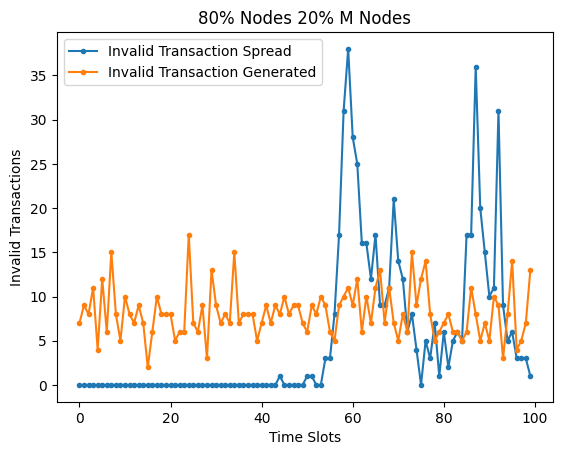

In [63]:
import matplotlib.pyplot as plt

plt.plot(maxd,marker='.',label='Invalid Transaction Spread')
plt.plot(cntinv,marker='.',label='Invalid Transaction Generated')
plt.legend()

title=str(h)+"% Nodes "+str(100-h)+"% M Nodes"
plt.title(title)
plt.xlabel("Time Slots")
plt.ylabel("Invalid Transactions")
plt.show()

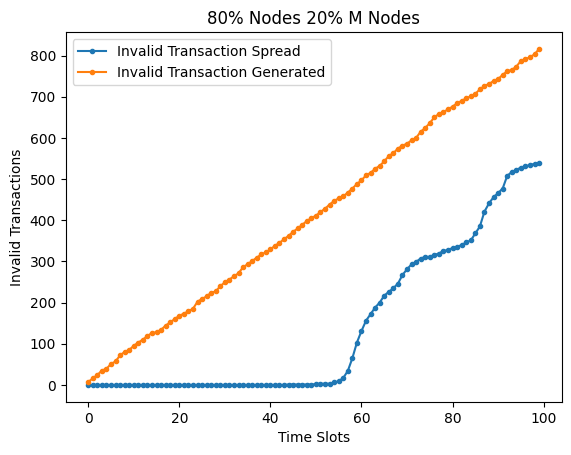

In [64]:
import matplotlib.pyplot as plt
cspr=[maxd[0]]
cinv=[cntinv[0]]

for i in range(1,len(maxd)):
    cspr.append(cspr[i-1]+maxd[i])
    cinv.append(cinv[i-1]+cntinv[i])
    
plt.plot(cspr,marker='.',label='Invalid Transaction Spread')
plt.plot(cinv,marker='.',label='Invalid Transaction Generated')
plt.legend()
title=str(h)+"% Nodes "+str(100-h)+"% M Nodes"
plt.title(title)
plt.xlabel("Time Slots")
plt.ylabel("Invalid Transactions")
plt.show()